In [1]:
import csv
import numpy as np
import pandas as pd
from collections import defaultdict
import string
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
from sklearn import metrics # confusion matrix, MSE etc.

In [2]:
path_to_data = "/Users/t.z.cheng/Google_Drive/Research/Delaydoesmatter/real_exp/exp4_20CR12/4c/results/session-62159fb8dfe54372fbc126e5-data.csv"

In [3]:
## Read the data
df = pd.read_csv(path_to_data)
# df.groupby('stimuli_presented').describe()

In [4]:
## Tasks & Conditions: Clean up task and subject ID (first five characters)
df['task'] = df['trial_template'].apply(lambda x: x.split("_")[0])
df['sub_id'] = df['participant_id'].apply(lambda x: x.split()[0][0:5])

In [5]:
## Add the accuracy and PPS column to the dataset: transform True and Shorter to 1, False and longer to 0
Correct = [] # only applied for the prescreen
Shorter = []
for i in np.arange(0,len(df)):
    if df['response_correct'][i] == True:
        Correct.append(1)
    else: 
        Correct.append(0)
    if df['response_value'][i] == "Shorter":
        Shorter.append(1)
    else: 
        Shorter.append(0)
df['Correct'] = Correct
df['Shorter'] = Shorter

In [6]:
## Total participated subjects
len(df['sub_id'].unique())

75

## Set parameters
- Accuracy threshold for the easiest trials of the main task 
- Extreme RT threshold
- Catch trial accuracy

In [7]:
## Parameters
threshold = .55
catch_threshold = .7
RT_threshold = 10000
practice_threshold = 'pass'

## Data cleaning 
***Super important: df_clean is overwritten after each step of data cleaning***

**Reject subjects**
- Catch trial
- Environmental noise & audio device (may not need to use them as criteria)
- Fail the practice trial on the last 12 practice trial: pass people have done 24 trials, fail people have done 36 trials

**Reject trials**
- Task-relevant trials
- Extreme RT

In [8]:
## How many subjects miss the catch trial 
catch_trials = ['Catch_cat','Catch_bird']
df_catch = df[(df['trial_template'].isin(catch_trials))].reset_index(drop = True) # reset index from 1
catch_acc = df_catch.groupby('sub_id')['response_correct'].sum()/df_catch.groupby('sub_id')['response_correct'].count()
fail_catch = catch_acc[catch_acc < catch_threshold].reset_index()
fail_catch

,sub_id,response_correct
0,2338f,0.615385
1,57a9f,0.461538
2,6758a,0.423077
3,751fa,0.461538
4,91922,0.576923
5,a2903,0.615385
6,b7e1d,0.461538
7,cd75e,0.384615
8,faac2,0.615385


In [9]:
## remove subjects who failed the catch trial based on the threshold
df_clean = df[~df['sub_id'].isin(fail_catch['sub_id'])].reset_index(drop = True)

In [10]:
## How many subjects had a bad environmental noise and device
df_noise = df[(df['response_name'] == 'survey_noise')].reset_index(drop = True)
noise = df_noise.groupby('sub_id')['response_value'].sum()
too_noisy = noise[noise == '4'].reset_index()
too_noisy

,sub_id,response_value
0,139a5,4
1,b7e1d,4
2,cd116,4
3,de981,4


In [11]:
## remove subjects who completed the task in noisy environment
df_clean = df_clean[~df_clean['sub_id'].isin(too_noisy['sub_id'])].reset_index(drop = True)

In [12]:
# may remove subjects who completed the task using low-quality audio device
df_device = df[(df['response_name'] == 'survey_headphone1')].reset_index()
len(df_device[['sub_id','response_value']] == 'Yes')

75

In [13]:
## remove subjects who failed the practice 
fail_prac = df[df['branch_failpass'] == 'fail']['sub_id'].unique()
df_clean = df_clean[(~df_clean['sub_id'].isin(fail_prac))].reset_index()

In [14]:
## After cleaning how many subjects left
len(df_clean['sub_id'].unique())

59

### Task relevant trials
#### Select the trials to analyze
- Pretest trails (n = 60): single tone 1 or 8
- Practice trials (n = 24 or 36): 6 context tones + 1 ontime single tone 1 or 8 with correct/incorrect feedback
- Main task (n = 576): 6 context tones + 1 single tone (early, ontime, late; 1 to 8 steps) without feedback

### Select the pretest trials 

In [15]:
df_pre = df_clean[(df_clean['task'] == "PretestTrials")].reset_index()
df_pre.groupby(['sub_id','stimuli_presented'])['Correct'].mean()
pre_acc = df_pre.groupby(['sub_id'])['Correct'].mean()
conds = df_pre['stimuli_presented'].unique()
print(conds) # check the conditions
df_pre.groupby('stimuli_presented')['Shorter'].mean()

['short_tone_1' 'long_tone_8']


stimuli_presented
long_tone_8     0.096610
short_tone_1    0.923164
Name: Shorter, dtype: float64

### Select the practice trials

In [16]:
df_prac = df_clean[(df_clean['task'] == "practiceTrials")].reset_index()
conds = df_prac['stimuli_presented'].unique()
print(conds) # check the conditions
df_prac.groupby('stimuli_presented')['Shorter'].mean()

['single_300ms_ontime_delay_2_tone_Lab_1'
 'single_300ms_ontime_delay_2_tone_Lab_8']


stimuli_presented
single_300ms_ontime_delay_2_tone_Lab_1    0.906780
single_300ms_ontime_delay_2_tone_Lab_8    0.087571
Name: Shorter, dtype: float64

In [17]:
df_clean_all = df_clean # create a new variable just in case

## ??? under progress, need to write a code to save those *fail* who but pass on the last 12 trials??? 

In [18]:
# df_pra = df_pra[-12:-1]
# df_pra.groupby(['sub_id','stimuli_presented'])['Correct'].mean()
# pra_acc = df_pra.groupby(['sub_id'])['Correct'].mean()
# fail_pra = pra_acc[pra_acc != practice_threshold].reset_index()

### Select the main trials

In [19]:
df_clean = df_clean[(df_clean['task'] == "maintaskTrials")].reset_index(drop = True)
conds = df_clean['stimuli_presented'].unique()
print(conds) # check the conditions

['single_300ms_early_delay_2_tone_Lab_1'
 'single_300ms_late_delay_2_tone_Lab_4'
 'single_300ms_late_delay_2_tone_Lab_2'
 'single_300ms_ontime_delay_2_tone_Lab_8'
 'single_300ms_late_delay_2_tone_Lab_6'
 'single_300ms_ontime_delay_2_tone_Lab_7'
 'single_300ms_late_delay_2_tone_Lab_3'
 'single_300ms_ontime_delay_2_tone_Lab_4'
 'single_300ms_early_delay_2_tone_Lab_5'
 'single_300ms_late_delay_2_tone_Lab_1'
 'single_300ms_ontime_delay_2_tone_Lab_6'
 'single_300ms_ontime_delay_2_tone_Lab_5'
 'single_300ms_late_delay_2_tone_Lab_7'
 'single_300ms_ontime_delay_2_tone_Lab_1'
 'single_300ms_late_delay_2_tone_Lab_8'
 'single_300ms_late_delay_2_tone_Lab_5'
 'single_300ms_early_delay_2_tone_Lab_3'
 'single_300ms_ontime_delay_2_tone_Lab_3'
 'single_300ms_early_delay_2_tone_Lab_2'
 'single_300ms_early_delay_2_tone_Lab_6'
 'single_300ms_early_delay_2_tone_Lab_4'
 'single_300ms_ontime_delay_2_tone_Lab_2'
 'single_300ms_early_delay_2_tone_Lab_8'
 'single_300ms_early_delay_2_tone_Lab_7']


In [20]:
## Create new cols for onset and length
onset = []
length = []
df_clean = df_clean.set_index(pd.Index(np.arange(0,len(df_clean)))) # change the index for the for loop

for i in np.arange(0,len(df_clean)):
    stimuli_presented = df_clean['stimuli_presented'][i].split('_')
    onset.append(stimuli_presented[2])
    length.append(stimuli_presented[-1])
df_clean['Onset'] = onset
df_clean['Length'] = length

In [21]:
## Number of subjects, trials & conditions for each subjects
n_subj = len(df_clean['participant_id'].unique())
n_trial = len(df_clean)//n_subj # how many trials per subject
n_conds = len(df_clean['stimuli_presented'].unique())
print('Participant_number:', n_subj,'Trial number:', n_trial,'Condition number:', n_conds, sep='\n')

Participant_number:
59
Trial number:
288
Condition number:
24


### Accuracy

In [22]:
df_clean.groupby(['Onset'])['Correct'].mean()

Onset
early     0.755473
late      0.745586
ontime    0.752648
Name: Correct, dtype: float64

In [23]:
accuracy_all = df_clean.groupby(['stimuli_presented','Onset'])['Correct'].mean()

In [24]:
## consider outliers based on the accuracy of the easiest trials 
outliers = Acc_easiest < threshold
outliers = outliers[outliers == True]
df_clean_nooutlier = df_clean[~df_clean['participant_id'].isin(outliers.index)]

NameError: name 'Acc_easiest' is not defined

In [ ]:
## Visualization: bar plot
ACC_plot = pd.DataFrame({'Conditions': conds, 'accuracy': accuracy_all})
ax = ACC_plot.plot.bar(rot = 0)

### Proportion short

In [25]:
df_clean.groupby(['Onset'])['Shorter'].mean()

Onset
early     0.483934
late      0.433086
ontime    0.453919
Name: Shorter, dtype: float64

In [26]:
pps = df_clean.groupby(['Onset'])['Shorter'].mean()
print('Proportion short')
print('Early',pps[0]) 
print('Ontime',pps[2])
print('Late',pps[1])

Proportion short
Early 0.483933615819209
Ontime 0.4539194915254237
Late 0.4330861581920904


In [27]:
pps_all = df_clean.groupby(['stimuli_presented','Onset'])['Shorter'].mean()

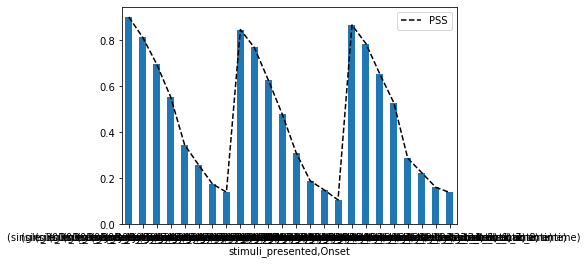

In [28]:
## Visualization: bar plot
PPS_plot = pd.DataFrame({'Conditions': conds, 'PSS': pps_all})
ax = PPS_plot.plot.bar(rot = 0)
pps_all.plot(style='k--')

In [29]:
pps_all[8:16]

stimuli_presented                     Onset
single_300ms_late_delay_2_tone_Lab_1  late     0.844633
single_300ms_late_delay_2_tone_Lab_2  late     0.766949
single_300ms_late_delay_2_tone_Lab_3  late     0.625706
single_300ms_late_delay_2_tone_Lab_4  late     0.477401
single_300ms_late_delay_2_tone_Lab_5  late     0.309322
single_300ms_late_delay_2_tone_Lab_6  late     0.187853
single_300ms_late_delay_2_tone_Lab_7  late     0.148305
single_300ms_late_delay_2_tone_Lab_8  late     0.104520
Name: Shorter, dtype: float64

[Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8')]

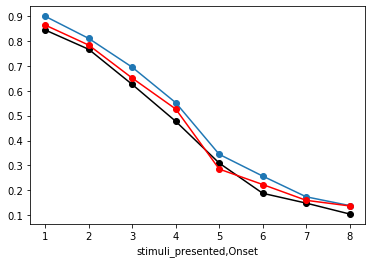

In [30]:
pps_all[0:8].plot(style = 'o-') # early
pps_all[8:16].plot(style ='ko-') # late
ax = pps_all[16:24].plot(style ='ro-') # ontime
ax.set_xticklabels([0,1,2,3,4,5,6,7,8])

### Statistic tests

In [31]:
PPS = df_clean.groupby(['sub_id','Onset'])['Shorter'].mean()
PPS_early = PPS[::3]
PPS_ontime = PPS[1::3]
PPS_late = PPS[2::3]

In [32]:
print(stats.ttest_rel(PPS_early, PPS_late))
print(stats.ttest_rel(PPS_early, PPS_ontime))
print(stats.ttest_rel(PPS_late, PPS_ontime))

Ttest_relResult(statistic=3.419153748921935, pvalue=0.0011555473599086073)
Ttest_relResult(statistic=4.5525418374144895, pvalue=2.7659018024425814e-05)
Ttest_relResult(statistic=2.4395295341163803, pvalue=0.0177855756562612)


## Save the onset and comparison length to the csv file for R analysis

In [ ]:
## save df to csv
df_clean.to_csv(r'/Users/t.z.cheng/Google_Drive/Research/Delaydoesmatter/real_exp/exp4_20CR12/4c/results/EXP4c_clean_n59.csv', header=True)